<a href="https://colab.research.google.com/github/bivek2211/Tensorflow2.0/blob/master/MNIST_Tensorflow_2_0_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow_gpu==2.0.0a0

    100% |████████████████████████████████| 332.1MB 42kB/s 
    100% |████████████████████████████████| 61kB 14.6MB/s 
    100% |████████████████████████████████| 3.0MB 5.4MB/s 
    100% |████████████████████████████████| 419kB 7.0MB/s 


In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

tf.__version__

'2.0.0-alpha0'

In [0]:
## Defining parameters
num_classes = 10

learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Nwork parameter
conv1_filters = 32 # no of filter for 1st conv layer
conv2_filters = 64 # no of filters for 2nd conv layer
fc1_units = 1024 # no of neurons for 1st fully connected layer

In [0]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [0]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024)
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [0]:
# Cross-Entropy Loss.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [0]:
# Optimization process. 
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = conv_net(x, is_training=True)
        # loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [0]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 1.883011, accuracy: 0.835938
step: 20, loss: 1.603623, accuracy: 0.921875
step: 30, loss: 1.562955, accuracy: 0.937500
step: 40, loss: 1.576540, accuracy: 0.937500
step: 50, loss: 1.539285, accuracy: 0.953125
step: 60, loss: 1.503084, accuracy: 0.976562
step: 70, loss: 1.529256, accuracy: 0.953125
step: 80, loss: 1.538274, accuracy: 0.960938
step: 90, loss: 1.517756, accuracy: 0.968750
step: 100, loss: 1.535501, accuracy: 0.945312
step: 110, loss: 1.521195, accuracy: 0.968750
step: 120, loss: 1.513290, accuracy: 0.968750
step: 130, loss: 1.495914, accuracy: 0.984375
step: 140, loss: 1.499886, accuracy: 0.976562
step: 150, loss: 1.501424, accuracy: 0.976562
step: 160, loss: 1.500288, accuracy: 0.992188
step: 170, loss: 1.498785, accuracy: 0.984375
step: 180, loss: 1.493701, accuracy: 0.968750
step: 190, loss: 1.500872, accuracy: 0.968750
step: 200, loss: 1.500425, accuracy: 0.976562


In [0]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.979300


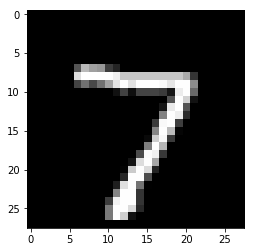

Model prediction: 7


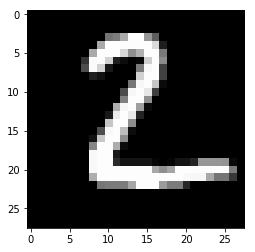

Model prediction: 2


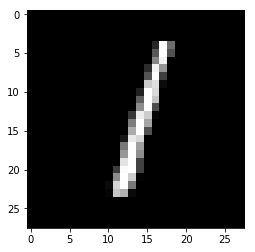

Model prediction: 1


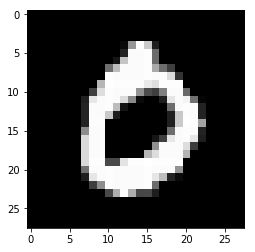

Model prediction: 0


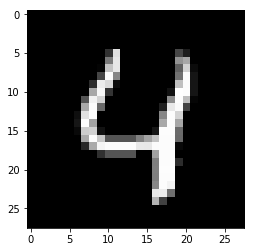

Model prediction: 4


In [0]:
import matplotlib.pyplot as plt

# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))